In [1]:
# Import pandas for reading in the data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

from joblib import dump, load

Using Theano backend.


In [2]:
top_stocks = pd.read_hdf('../data/clean/computed_stocks.h5', key='top_stocks')

top_stocks.reset_index(inplace=True)
top_stocks.drop_duplicates(['symbol', 'date'], inplace=True)
top_stocks.set_index('date', inplace=True)

In [3]:
top_stocks.index = pd.to_datetime(top_stocks.index)

In [4]:
# top_stocks = pd.concat([top_stocks['2007'],
#                         top_stocks['2009':'2010'],
#                         top_stocks['2012'],
#                         top_stocks['2014':]])

In [5]:
COLUMNS = []

with open('../models/columns.json') as column_file:
    COLUMNS = json.load(column_file)
    COLUMNS = list(filter(lambda x: 'market' not in x, COLUMNS))

In [6]:
def plot_classifier(clf, X_train, y_train, X_test, y_test):    
    
    y_pred_train = clf.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
    
    y_pred_test = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Coin Flip')
    plt.plot(fpr_train, tpr_train, label='Training Data')
    plt.plot(fpr, tpr, label='Testing Data')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
     
    print(f'Train AUC: {roc_auc_score(y_train, y_pred_train)}, Train F1 Score: {f1_score(y_train, y_pred_train.round())}')
    print(f'Test AUC: {roc_auc_score(y_test, y_pred_test)}, Test F1 Score: {f1_score(y_test, y_pred_test.round())}')
    print(f'Test Accuracy: {accuracy_score(y_test, clf.predict(X_test))}')

In [7]:
X = top_stocks[COLUMNS]
y = top_stocks['buy_signal']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

In [8]:
rus = RandomUnderSampler()
X_train, y_train = rus.fit_resample(X_train, y_train)

In [9]:
scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
clf = XGBClassifier(n_jobs=-1, verbosity=1)

clf.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=1)

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


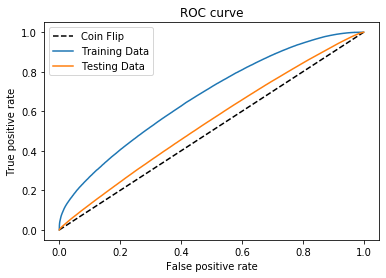

Train AUC: 0.6726438576136922, Train F1 Score: 0.6284605477805444
Test AUC: 0.5432410974165381, Test F1 Score: 0.568019379706492
Test Accuracy: 0.5324126639351007


['XGBoost.joblib']

In [11]:
plot_classifier(clf, X_train_scaled, y_train, X_test_scaled, y_test)
dump(clf, 'XGBoost.joblib')

In [12]:
clf = load('XGBoost.joblib')

In [13]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
[(COLUMNS[i], importances[i]) for i in indices]

[('bb_middle_5', 0.03104427),
 ('linear_regression_intercept_5', 0.028468732),
 ('natr_5', 0.027396692),
 ('ichimoku_cloud', 0.026666084),
 ('linear_regression_20', 0.026495578),
 ('linear_regression_slope_20', 0.025120517),
 ('std_20', 0.024870196),
 ('linear_regression_slope_5', 0.024639579),
 ('bb_upper_20', 0.024290668),
 ('std_5', 0.02409458),
 ('day_of_week', 0.023559034),
 ('ichimoku_a', 0.023332587),
 ('natr_20', 0.023263004),
 ('ichimoku_conversion', 0.023259725),
 ('will_r_5', 0.023033373),
 ('linear_regression_intercept_20', 0.023004346),
 ('tema_20', 0.022832064),
 ('linear_regression_angle_5', 0.022782678),
 ('adxr_20', 0.022752278),
 ('tema_5', 0.022669662),
 ('macd_signal', 0.02234927),
 ('bb_upper_5', 0.022301676),
 ('ichimoku_b', 0.022278232),
 ('macd_line', 0.022268506),
 ('ichimoku_base', 0.022148715),
 ('adxr_5', 0.02191153),
 ('linear_regression_angle_20', 0.021866044),
 ('trix_20', 0.02183779),
 ('rsi_20', 0.02183665),
 ('tsf_20', 0.021581542),
 ('bb_middle_20', 0